# DiT Reproduction 

In [2]:
import numpy as np
import torch as T
import torch.nn as nn
import random
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)

In [3]:
mps = T.device("mps")

## Data Exploration/Dataset Generation

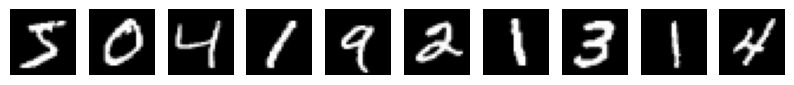

In [146]:
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(mnist[i][0].squeeze(), cmap="grey")
    ax.axis("off")

In [74]:
import math
s = 1e-5
cos_scheduler = lambda x: math.cos((x/50 + s)/(1+s) * math.pi/2)**2

## noise scheduling

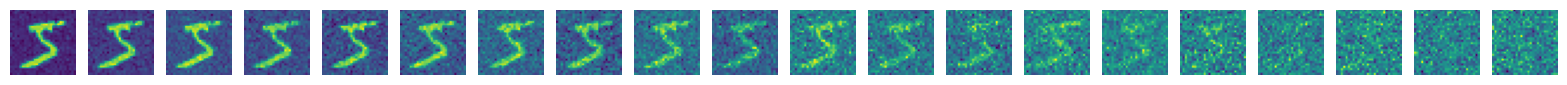

In [148]:
beta = 0.15
alpha = 1-beta

alphas = [alpha*cos_scheduler(i) for i in range(20)]
alphas_prod = T.cumprod(T.tensor(alphas), dim=0)

noise = lambda shape: T.normal(mean=T.zeros(shape), std=0.5)

def get_noised_pairs(img, c, r=20):
    pairs = []
    img = img/img.max()
    for i in range(r):
        no = noise(img.shape)

        # scaling the original image down, and scaling the noise to the inverse amount, so distributions stay ~similar
        noised = math.sqrt(alphas_prod[i])*img + math.sqrt(1-alphas_prod[i])*no
        pairs.append((
            noised,
            no,
            r-i,
            c
        ))
    return pairs

img = mnist[0][0][0]
img = img/img.max()*2 - 1

fig = plt.figure(figsize=(25, 25))

p = get_noised_pairs(img, 0)

for i in range(20):
    ax = fig.add_subplot(1, 25, i+1)
    img = p[i][0]
    ax.imshow(img)
    ax.axis("off")

In [149]:
mnist = [get_noised_pairs(img[0], img[1]) for img in mnist]
mnist = [j for i in mnist for j in i]

KeyboardInterrupt: 

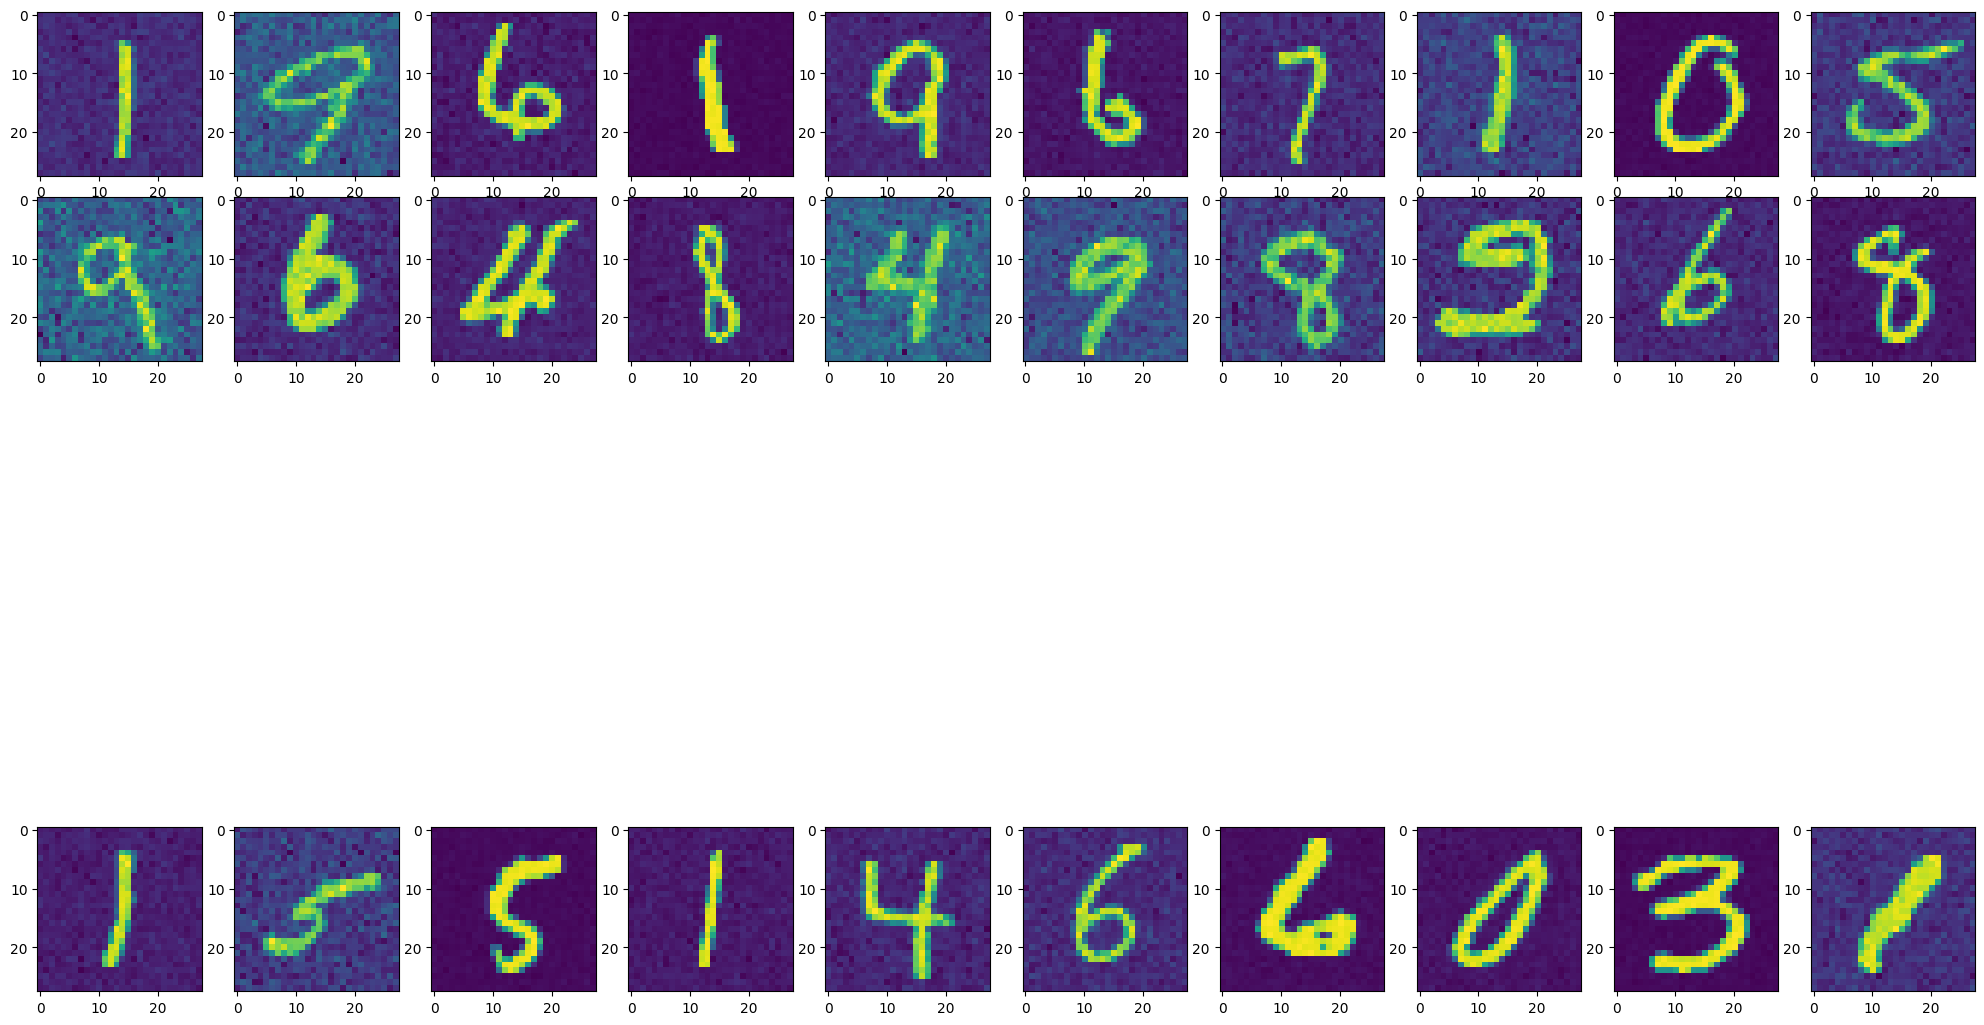

In [ ]:
# lets check the noise

fig = plt.figure(figsize=(25, 30))

for i, im in enumerate(random.sample(mnist, 30)):
    ax = fig.add_subplot(i//10 + 1, 10, i%10+1)
    plt.imshow(im[0][0].squeeze() - im[1][0].squeeze())
    # plt.imshow(im[1][0].squeeze())

### Model Classes

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, latent_dim):
        super(LayerNorm, self).__init__()
        self.mean = nn.Parameter(T.zeros(latent_dim))
        self.sd = nn.Parameter(T.ones(latent_dim))

    def forward(self, x):
        return x * self.sd + self.mean

class AdaLN(nn.Module):
    def __init__(self, latent_dim, out_dim=None):
        super(AdaLN, self).__init__()
        out_dim = latent_dim if out_dim == None else out_dim
        self.mean = nn.Linear(latent_dim, out_dim)
        self.sd = nn.Linear(latent_dim, out_dim)
        self.ln = LayerNorm(out_dim)

    def forward(self, x, t, c):
        t = F.silu(t + c)
        mean = self.mean(t)
        sd = self.sd(t)

        #mean = T.clip(mean, max=3)
        #sd = T.clip(sd, max=3)
        return self.ln(x*sd + mean)

In [5]:
class Transformer(nn.Module):
    def __init__(self, seq_len, heads, latent_dim, dim_out,  steps=21, classes=10, mask=None, dropout=0.05):
        super(Transformer, self).__init__()
        self.proj = nn.Linear(seq_len, latent_dim)
        self.proj_q = nn.Linear(latent_dim, latent_dim)
        self.proj_k = nn.Linear(latent_dim, latent_dim)
        self.proj_v = nn.Linear(latent_dim, latent_dim)

        self.layer_norm1 = AdaLN(latent_dim)
        self.layer_norm2 = AdaLN(latent_dim)

        self.mask = mask
        self.seq_len = seq_len
        self.heads = heads
        self.latent_dim = latent_dim

        self.ffn = nn.Sequential(
            nn.Linear(latent_dim, dim_out * 4),
            nn.GELU(),
            nn.Linear(dim_out * 4, dim_out),
        )
        
        self.dropout = nn.Dropout(p=0.2)


    def forward(self, x, t, c):
        x = x # (bs, emb, seq_len)
        x = self.proj(x) # (bs, emb, seq_len) => (bs, emb, latent)
        bs = x.shape[0] 
        emb_size = x.shape[1]
        res = x
        x = self.layer_norm1(x, t, c)

        q, k, v = [layer(x).reshape(bs, -1, self.heads, self.latent_dim//self.heads) for layer in [self.proj_q, self.proj_k, self.proj_v]]
        q = q.permute(0, 2, 3, 1)
        k = k.permute(0, 2, 3, 1)
        v = v.permute(0, 2, 3, 1)
        attn = F.scaled_dot_product_attention(q, k, v, is_causal=False)#,attn_mask=self.mask)
        attn = attn.reshape(bs, self.latent_dim, emb_size).permute(0, 2, 1)
        x = res + attn

        x = self.layer_norm2(x, t, c)
        return self.ffn(x)

In [61]:
class PositionalEmbedding(nn.Module):
    def __init__(self, seq_len, patch_size, d_model):
        super(PositionalEmbedding, self).__init__()
        dims = [T.arange(0,seq_len)/10000**(i/d_model) for i in range(patch_size**2)]
        dims = T.stack(dims, dim=0).to(mps)

        dims[0::2] = T.sin(dims[0::2])
        dims[1::2] = T.cos(dims[1::2])

        self.pos = dims

    def forward(self, x):
        return x + self.pos

In [7]:
class DiT(nn.Module):
    def __init__(self, layers, seq_len, patch_size, n_heads, steps=21, classes=10, latent_dim=None):
        super(DiT, self).__init__()
        assert (seq_len**0.5).is_integer()

        self.latent_dim = latent_dim if latent_dim != None else seq_len // 2
        self.size = int(patch_size * seq_len**0.5)
        self.patch_size = patch_size
        self.seq_len = seq_len

        self.emb = PositionalEmbedding(seq_len, patch_size, 3)

        self.transformer_block = nn.ModuleList(
            [Transformer(seq_len, n_heads, latent_dim, seq_len, steps=steps, classes=classes) for _ in range(layers)]
        )

        self.layer_norm = AdaLN(latent_dim, seq_len)

        self.proj_out = nn.Linear(seq_len, seq_len)

        self.emb_step = nn.Embedding(steps, latent_dim)
        self.emb_time = nn.Embedding(classes, latent_dim)
    
    def forward(self, x, t, c):
        bs = x.shape[0]
        x = F.unfold(x, kernel_size=(self.patch_size, self.patch_size), stride=self.patch_size)
        x = self.emb(x)

        t = self.emb_step(t)
        c = self.emb_time(c)
        
        for layer in self.transformer_block:
            x = layer(x, t, c)

        x = self.layer_norm(x, t , c)
        x = self.proj_out(x)
        return F.fold(x, output_size=(self.size,self.size), kernel_size=(self.patch_size, self.patch_size), stride=self.patch_size)

In [ ]:
# model = nn.Sequential(*[Transformer(49, 10, 100, 49) for _ in range(3)])

In [ ]:
# model = DiT(3, 49, 4, 10, latent_dim=100)

In [ ]:
bs = 64
dataloader = DataLoader(mnist, batch_size=bs, shuffle=True)

In [ ]:
import torch.nn.utils as utils
max_norm = 10
device = T.device("mps")
steps=25
model = DiT(2, 49, 4, 8, latent_dim=64, steps=21, classes=11)
# model = T.compile(model)
opt = T.optim.AdamW(model.parameters(), lr=1e-3)
loss_graph = []

model.to(device)
i = 0
for epoch in range(30):
    for x, y, t, c in dataloader:
        # classifier free guidance
        c[(T.rand(64)*20).int() < 1] = 10
        y_pred = model(x.to(device), t.unsqueeze(dim=1).to(device), c.unsqueeze(dim=1).to(device))

        loss = ((y_pred - y.to(device))**2).mean()
        loss.backward()

        utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        opt.zero_grad()
        loss_graph.append(loss.item())
        if i % 100 == 0:
            print(f"loss {loss.item()} i {i} epoch {epoch}")
        i+=1
    T.save(model.state_dict(), f"model_weights_{epoch}.tf")

loss 0.32196861505508423 i 0 epoch 0
loss 0.24292388558387756 i 100 epoch 0
loss 0.19090761244297028 i 200 epoch 0
loss 0.1630515158176422 i 300 epoch 0
loss 0.13491608202457428 i 400 epoch 0


KeyboardInterrupt: 

## experimenting with the model!

In [ ]:
len(loss_graph)

2979

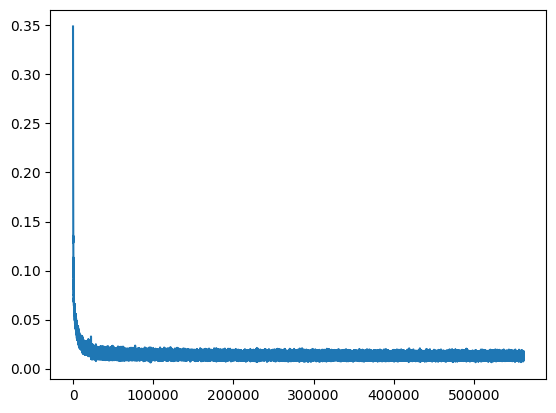

In [158]:
window_size = 1
smoothed_loss = np.convolve(loss_graph, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_loss)

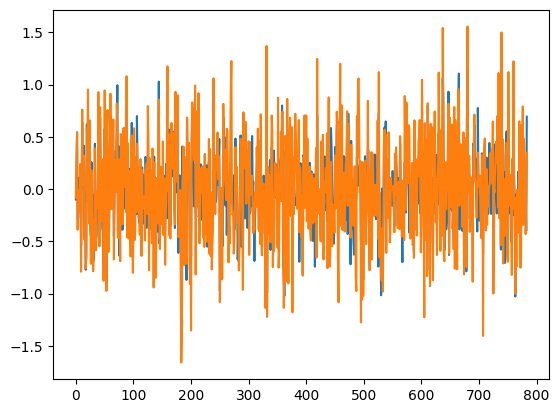

In [159]:
# good gut check for distribution

plt.plot(y_pred[0].flatten().cpu().detach())
plt.plot(y[0].flatten().cpu().detach())

### load weights

In [62]:
model = DiT(2, 49, 4, 8, latent_dim=64, steps=21, classes=11)
mp = T.load("/Users/neelredkar/Downloads/model_weights_ln_29.tf", map_location=T.device('mps'))
model.load_state_dict(mp)

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_35164/1733865722.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mp = T.load("/Users/neelredkar/Downloads/mode

<All keys matched successfully>

In [63]:
loss_graph = T.load("/Users/neelredkar/Downloads/loss_29.pkl")

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_35164/1045397154.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_graph = T.load("/Users/neelredkar/Downlo

In [ ]:
plt.imshow(y_pred[4].cpu().detach().squeeze())

NameError: name 'y_pred' is not defined

In [12]:
def sample(im, t, c):
    assert t < 21
    assert c < 11
    return model(im.to("mps"), T.tensor([t]).unsqueeze(dim=0).to("mps"), T.tensor([c]).unsqueeze(dim=0).to("mps"))

In [65]:
model.to("mps")

DiT(
  (emb): PositionalEmbedding()
  (transformer_block): ModuleList(
    (0-1): 2 x Transformer(
      (proj): Linear(in_features=49, out_features=64, bias=True)
      (proj_q): Linear(in_features=64, out_features=64, bias=True)
      (proj_k): Linear(in_features=64, out_features=64, bias=True)
      (proj_v): Linear(in_features=64, out_features=64, bias=True)
      (layer_norm1): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (layer_norm2): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=196, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=196, out_features=49, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)

In [ ]:
alphas

tensor([1.4062e-01, 8.1166e-02, 3.6742e-02, 9.2871e-03, 3.1870e-33, 9.2871e-03,
        3.6742e-02, 8.1166e-02, 1.4062e-01, 2.1250e-01, 2.9366e-01, 3.8057e-01,
        4.6942e-01, 5.5632e-01, 6.3749e-01, 7.0937e-01, 7.6883e-01, 8.1325e-01,
        8.4071e-01, 8.5000e-01], device='mps:0')

## sampling techniques

1. most basic, just linearly decode

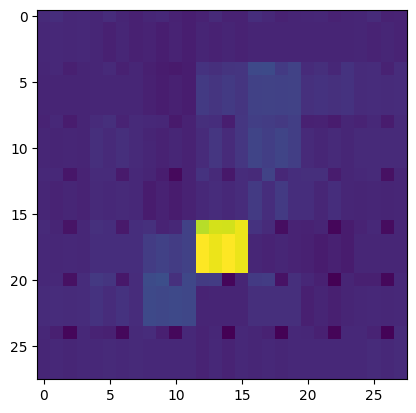

In [68]:
model.eval()
im = T.normal(mean=T.zeros(28,28), std=0.5).unsqueeze(dim=0).unsqueeze(dim=0).to("mps")

steps = 21
for i in range(steps):
    im  -= sample(im, i, 2)
plt.imshow(im.squeeze().squeeze().cpu().detach())

2. add some cfg

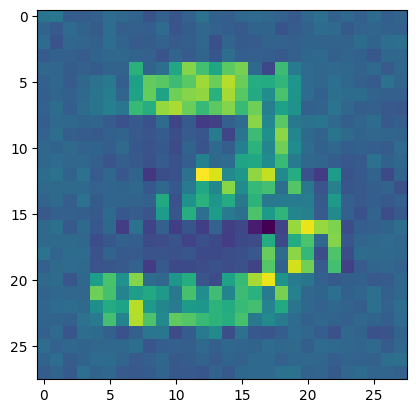

In [72]:
model.eval()
im = T.normal(mean=T.zeros(28,28), std=0.5).unsqueeze(dim=0).unsqueeze(dim=0).to("mps")

steps = 21
for i in range(steps):
    im  -= (sample(im, i, 3) - sample(im, i, 10)*0.9)
plt.imshow(im.squeeze().squeeze().cpu().detach())

3. maybe we should scale the noise correctly

In [75]:
beta = 0.15
alpha = 1-beta

alphas = [alpha*cos_scheduler(i) for i in range(20)][::-1]
alphas_prod = T.cumprod(T.tensor(alphas), dim=0).to("mps")
betas = 1 - T.tensor(alphas).to("mps")

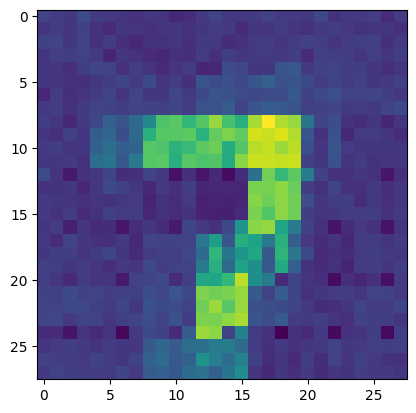

In [85]:
im = T.normal(mean=T.zeros(28,28), std=0.5).unsqueeze(dim=0).unsqueeze(dim=0).to("mps")
gamma = 2
steps = 25
def random_noise_like(im):
    return T.randn_like(im)


substeps = 5
for i in range(steps):
    t = int((i/steps) * 20)
    
    noise  = sample(im, t, 7) - sample(im, t, 10)*0.1

    im  = (1/math.sqrt(alphas[t])) *(im - noise*(1-alphas[t])/(math.sqrt(1-alphas_prod[t]))) + random_noise_like(im)*0.001
plt.imshow(im.squeeze().squeeze().cpu().detach())

4. treat it like an ode

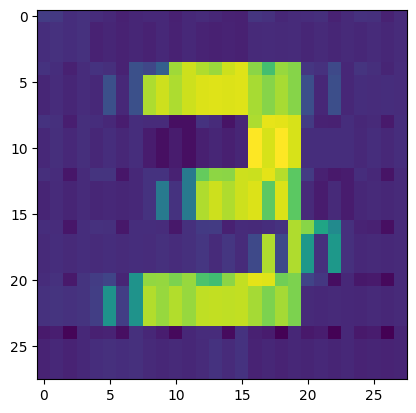

In [86]:
im = T.normal(mean=T.zeros(28,28), std=0.5).unsqueeze(dim=0).unsqueeze(dim=0).to("mps")
gamma = 2
steps = 40

substeps = 5
for i in range(steps):
    t = int((i/steps) * 20)
    noises = []

    for i in range(substeps):
        noise  = sample(im, t, 3) - sample(im, t, 10)*0.4
        noises.append(noise)
        im -= noise*0.1

    noise = T.vstack(noises).mean(dim=0)
    im  = (1/math.sqrt(alphas[t])) *(im - noise*(1-alphas[t])/(math.sqrt(1-alphas_prod[t])))
plt.imshow(im.squeeze().squeeze().cpu().detach())

In [161]:
model.to("mps")

DiT(
  (emb): PositionalEmbedding()
  (transformer_block): ModuleList(
    (0-1): 2 x Transformer(
      (proj): Linear(in_features=49, out_features=64, bias=True)
      (proj_q): Linear(in_features=64, out_features=64, bias=True)
      (proj_k): Linear(in_features=64, out_features=64, bias=True)
      (proj_v): Linear(in_features=64, out_features=64, bias=True)
      (layer_norm1): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (layer_norm2): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=196, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=196, out_features=49, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)

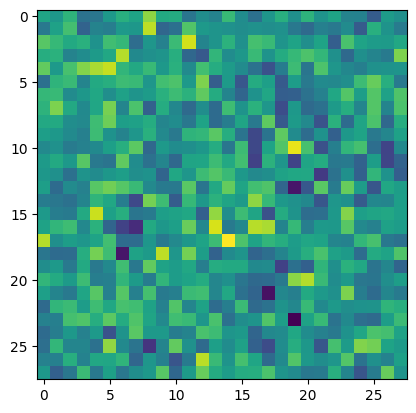

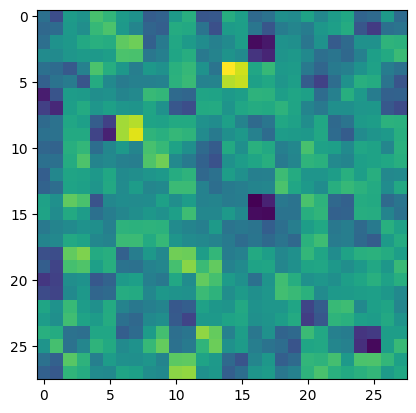

In [95]:
plt.imshow(mnist[1][0][0] - n)